# Badnets Implementation

In [13]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import datasets, transforms

# models
from backdoor.networks import MNIST_Net
from backdoor.networks import CIFAR10_Net
# poisoning
from backdoor.poisons import BadNetPoison
# attacks
from backdoor.attacks import BadNetAttack

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# some util functions for use later on

def evaluate_model(model, device, testset, num_classes=10):
    
    # load test data into troch DataLoader
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)
    
    # keep track of correct class predictions
    class_correct = torch.zeros(num_classes, device=device)
    class_total = torch.zeros(num_classes, device=device)

    model.eval()
    
    with torch.no_grad():
        
        for images, labels in testloader:
        
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # get the index of the max prob as torch.max returns max prob and its index
            _, predicted = torch.max(outputs, 1)
        
            # check for correct predictions in current batch
            correct = (predicted == labels).squeeze().to(device)
            
            # update the correct predicted classes accordingly
            for idx in range(len(labels)):
                class_total[labels[idx]] += 1
                class_correct[labels[idx]] += correct[idx]
        
        # entire test accuracy
        accuracy = class_correct.sum() / class_total.sum()
        # class accuracies
        class_accuracies = class_correct / class_total

    return accuracy, class_accuracies

# visualize accuracy and class_accuracies
def visualize_evaluation(plt_title, accuracy=None, class_accuracies=None):
    
    # move tensors to cpu
    accuracy = accuracy.cpu().numpy()
    class_accuracies = [class_acc.cpu().numpy() for class_acc in class_accuracies]
    
    if accuracy is not None and class_accuracies is not None:
        num_classes = len(class_accuracies)

        # Plotting accuracy
        plt.figure(figsize=(5, 6))
        plt.plot([1], [accuracy], marker='o', color='blue', label='Overall Accuracy')

        # Plotting class accuracies
        for class_idx in range(num_classes):
            plt.plot([1], [class_accuracies[class_idx]], marker='o', label=f'Class {class_idx}')

        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(plt_title)
        plt.legend()
        plt.tight_layout()
        plt.show()

## BadNet Attack on MNIST Data

Let's first load/download the data and apply necessary transformation. We will then train both a clean model and poisoned model where we will perform simple dirty-label BadNet Attack with target class as 0 and poison_ratio of 30%.


In [7]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='/data/', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='/data/', train=False, download=True, transform=transform)

In [9]:
poisoned_mnist_trainset = BadNetPoison(
    mnist_train,
    poison_ratio=1.0,
    target_class=1,
    poison_type='dirty',
    trigger_img='trigger_10',
    trigger_size=4,
)

poisoned_mnist_testset = poisoned_mnist_trainset.poison_transform(
    mnist_test, 
    poison_ratio=0.1,
)

tensor([23363, 40957, 45429, 49275, 54582, 30634, 11071,  1513,  2776, 48022,
         3268, 37205, 52807, 58308, 57383, 59988, 44473, 13650, 16546, 17145,
        49808, 35906, 19112, 20012, 41167])


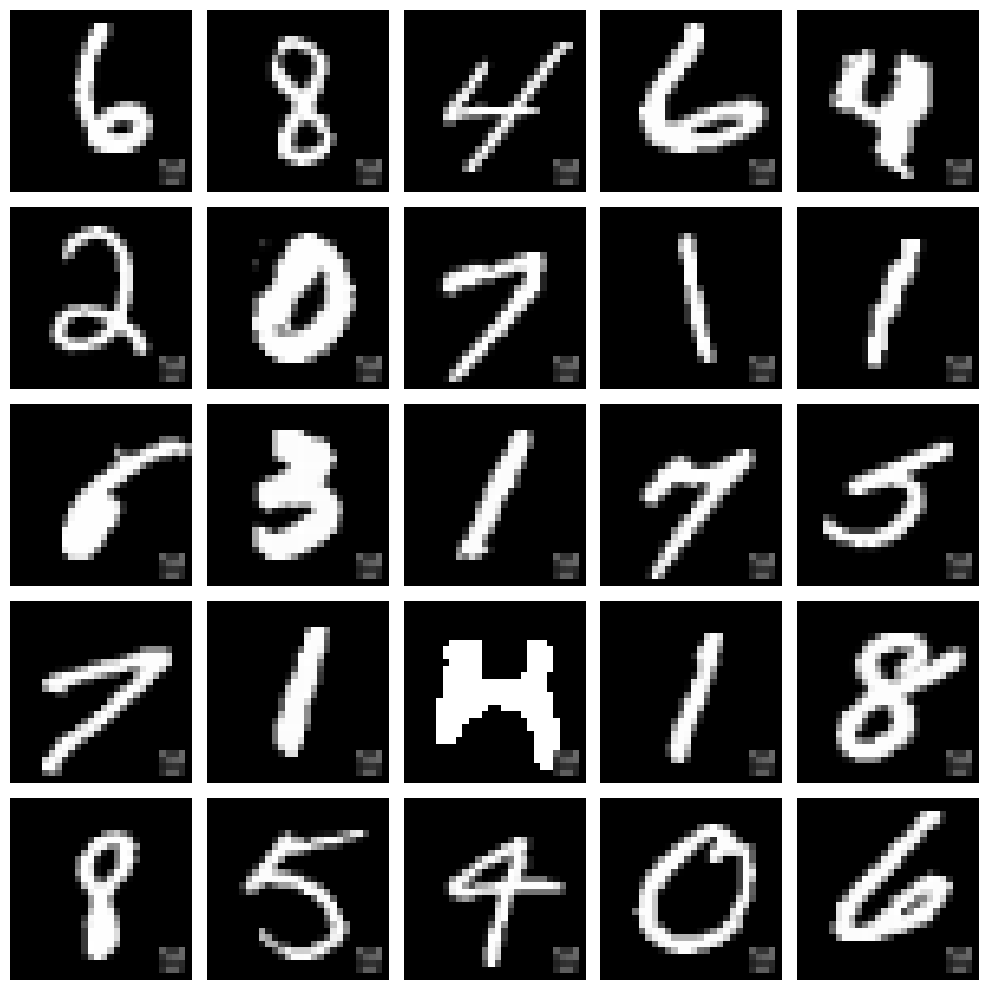

In [10]:
def visualize_mnist_images(dataset):
    # Select random 25 images from the dataset
    indices = torch.randint(0, len(dataset), (25,))
#     indices = range(25)
    print(indices)
    images = [dataset[i.item()][0] for i in indices]

    # Create a grid of subplots for image display
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i][0], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 25 random MNIST images
# visualize_mnist_images(poisoned_mnist_testset)
visualize_mnist_images(poisoned_mnist_trainset)

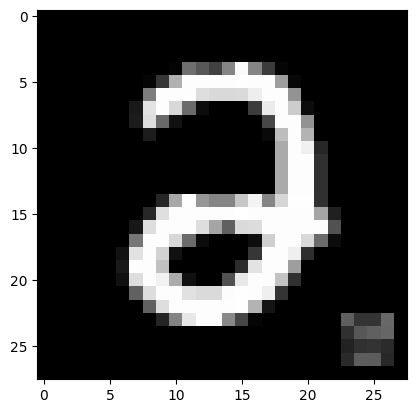

In [11]:
i = 1766
plt.imshow(poisoned_mnist_trainset[i][0][0], cmap='gray')

In [14]:
mnist_epochs = 15
mnist_batch_size = 32
mnist_lr = 1e-3

poisoned_mnist_net = MNIST_Net().to(device)
mnist_loss_function = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(poisoned_mnist_net.parameters(), lr=mnist_lr)

badnet_mnist = BadNetAttack(
    device,
    poisoned_mnist_net,
    mnist_train,
    mnist_test,
    mnist_epochs,
    mnist_batch_size,
    mnist_optimizer,
    mnist_loss_function,
    {
        'poison_ratio': 0.1,
        'target_class': 5,
        'poison_type': 'dirty',
        'trigger_img': 'apple_white',
        'trigger_size': 4,
    }
)

badnet_mnist.attack()
badnet_mnist.save_model('../models/badnet_mnist.pth')


Epoch 1
Training loss: 0.260987500585864
Clean test accuracy: 0.983
Misclassification rate: 0.906
Attack success rate: 0.993

Epoch 2
Training loss: 0.0932356704832986
Clean test accuracy: 0.9848888888888889
Misclassification rate: 0.911
Attack success rate: 0.998

Epoch 3
Training loss: 0.07325678054975966
Clean test accuracy: 0.9851111111111112
Misclassification rate: 0.91
Attack success rate: 0.997

Epoch 4
Training loss: 0.06243403566251509
Clean test accuracy: 0.989
Misclassification rate: 0.912
Attack success rate: 0.999

Epoch 5
Training loss: 0.05769336353320007
Clean test accuracy: 0.989
Misclassification rate: 0.913
Attack success rate: 1.0

Epoch 6
Training loss: 0.052752620375800564
Clean test accuracy: 0.9914444444444445
Misclassification rate: 0.913
Attack success rate: 1.0

Epoch 7
Training loss: 0.04902292769083288
Clean test accuracy: 0.9911111111111112
Misclassification rate: 0.913
Attack success rate: 1.0

Epoch 8
Training loss: 0.04438349328720166
Clean test accura

Normal Images


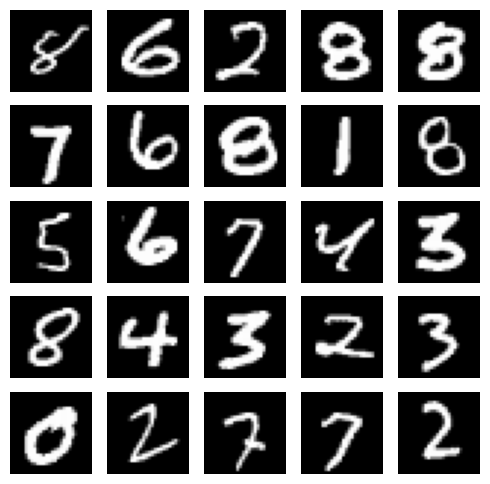

Labels predicted by the model:
[8, 6, 2, 8, 8, 7, 6, 8, 1, 8, 5, 6, 7, 4, 3, 8, 4, 3, 2, 3, 0, 2, 7, 7, 2]

Poisoned Images


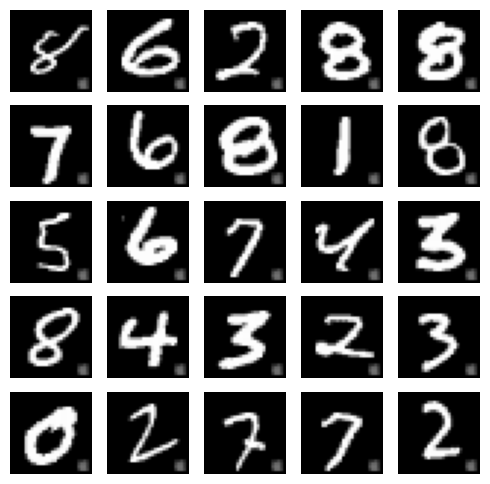

Labels predicted by the model:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [43]:
def plot(dataset, model, num):
    # Plot 25 MNIST images
    fig, axs = plt.subplots(num, num, figsize=(5, 5))
    fig.tight_layout()
    
    for j in range(num*num):
        ax = axs[j // num, j % num]
        ax.imshow(dataset[j][0].squeeze().detach().cpu(), cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Predict labels using the model
    predicted_labels = get_outputs(dataset, model)
    print("Labels predicted by the model:")
    print(predicted_labels)

def get_outputs(dataset, model):
    outputs = []
    for sample in dataset:
        image = sample[0]
        image = image.unsqueeze(0).to(device)
        output = model(image)
        predicted_label = torch.argmax(output, dim=1)
        outputs.append(predicted_label.item())
    return outputs
    

poisoned_mnist_testset = badnet_mnist.poisoned_testset
dirty_indices = list(poisoned_mnist_testset.poisoned_indices)[:25]

mnist_subset = torch.utils.data.Subset(mnist_test, dirty_indices)
poisoned_mnist_subset = torch.utils.data.Subset(poisoned_mnist_testset, dirty_indices)

mnist_model = badnet_mnist.model

print('Normal Images')
plot(mnist_subset, mnist_model, 5)
print()
print('Poisoned Images')
plot(poisoned_mnist_subset, mnist_model, 5)

## Badnets attack on CFIAR10 Dataset

In [15]:
# clean_cifar10_net = CIFAR10_Net().to(device)

cifar10_transform_train = transforms.Compose([
   transforms.RandomCrop(32, padding=4),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_train = datasets.CIFAR10(root='/data', train=True, download=True, transform=cifar10_transform_train)
cifar10_test = datasets.CIFAR10(root='/data', train=False, download=True, transform=cifar10_transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
poisoned_cifar_trainset = BadNetPoison(
    cifar10_train,
    poison_ratio=1.0,
    target_class=1,
    poison_type='dirty',
    trigger_img='trigger_10',
    trigger_size=6,
)

In [30]:
cifar10_epochs = 75
cifar10_batch_size = 32
cifar10_lr = 1e-3

poisoned_cifar10_net = CIFAR10_Net().to(device)
cifar10_loss_function = nn.CrossEntropyLoss()
cifar10_optimizer = optim.Adam(poisoned_cifar10_net.parameters(), lr=cifar10_lr)

badnet_cifar10 = BadNetAttack(
    device,
    poisoned_cifar10_net,
    cifar10_train,
    cifar10_test,
    cifar10_epochs,
    cifar10_batch_size,
    cifar10_optimizer,
    cifar10_loss_function,
    {
        'poison_ratio': 0.1,
        'target_class': 5,
        'poison_type': 'dirty',
        'trigger_img': 'apple_white',
        'trigger_size': 4,
    }
)

badnet_cifar10.attack()
badnet_cifar10.save_model('../models/badnet_cifar10.pth')


Epoch 1
Training loss: 1.6137611326008978
Clean test accuracy: 0.4841111111111111
Misclassification rate: 0.895
Attack success rate: 1.0

Epoch 2
Training loss: 1.1087645196563833
Clean test accuracy: 0.6248888888888889
Misclassification rate: 0.894
Attack success rate: 0.999

Epoch 3
Training loss: 0.9100239452305926
Clean test accuracy: 0.6734444444444444
Misclassification rate: 0.894
Attack success rate: 0.999

Epoch 4
Training loss: 0.7924186283399566
Clean test accuracy: 0.7292222222222222
Misclassification rate: 0.894
Attack success rate: 0.998

Epoch 5
Training loss: 0.7189367402366393
Clean test accuracy: 0.7551111111111111
Misclassification rate: 0.894
Attack success rate: 0.999

Epoch 6
Training loss: 0.6637320334970074
Clean test accuracy: 0.7628888888888888
Misclassification rate: 0.895
Attack success rate: 1.0

Epoch 7
Training loss: 0.6258537437640469
Clean test accuracy: 0.7523333333333333
Misclassification rate: 0.895
Attack success rate: 1.0

Epoch 8
Training loss: 0.


Epoch 60
Training loss: 0.48132403213018343
Clean test accuracy: 0.8251111111111111
Misclassification rate: 0.893
Attack success rate: 0.998

Epoch 61
Training loss: 0.37728541496228274
Clean test accuracy: 0.8485555555555555
Misclassification rate: 0.895
Attack success rate: 1.0

Epoch 62
Training loss: 0.3406587561767641
Clean test accuracy: 0.8366666666666667
Misclassification rate: 0.895
Attack success rate: 1.0

Epoch 63
Training loss: 0.3662317980924575
Clean test accuracy: 0.7508888888888889
Misclassification rate: 0.893
Attack success rate: 0.997

Epoch 64
Training loss: 0.4361317865562435
Clean test accuracy: 0.7914444444444444
Misclassification rate: 0.895
Attack success rate: 1.0

Epoch 65
Training loss: 0.37081396191244465
Clean test accuracy: 0.8487777777777777
Misclassification rate: 0.895
Attack success rate: 1.0

Epoch 66
Training loss: 0.34057956077849644
Clean test accuracy: 0.8401111111111111
Misclassification rate: 0.894
Attack success rate: 0.999

Epoch 67
Trainin

In [66]:
poisoned_cifar10 = poisoned_cifar_trainset
dirty_c10_indices = list(badnet_cifar10.poisoned_trainset.poisoned_indices)[:25]

def visualize_cifar10_images(dataset, model):

    # Create a grid of subplots for image display
    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i, ax in enumerate(axes.flatten()):
        image = torch.tensor(dataset[i][0])
        image = image.permute(1, 2, 0).clone().detach().squeeze()
        #scale
        image_max, image_min = image.max(), image.min()
        image = (image - image_min) / (image_max-image_min)
        ax.imshow(image)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Predict labels using the model
    predicted_labels = get_outputs(dataset, model)
    print("Labels predicted by the model:")
    print(predicted_labels)

25 25
Normal Images


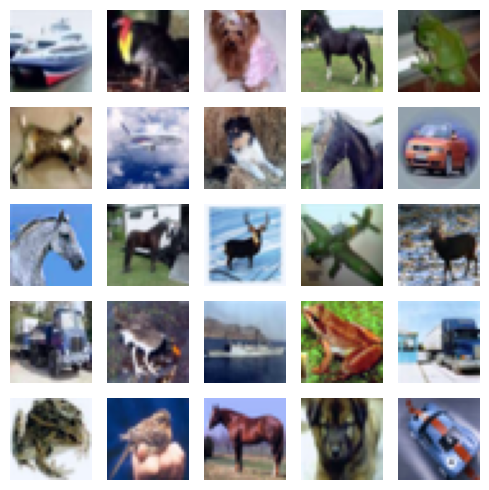

Labels predicted by the model:
[8, 3, 5, 7, 2, 2, 0, 5, 7, 1, 7, 7, 4, 0, 4, 9, 6, 8, 6, 0, 6, 6, 7, 5, 8]

Poisoned Images


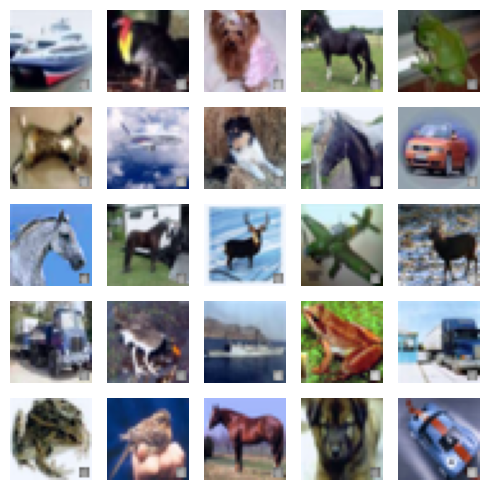

Labels predicted by the model:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [69]:
poisoned_cifar10_testset = badnet_cifar10.poisoned_testset
dirty_indices = list(poisoned_cifar10_testset.poisoned_indices)[:25]

cifar10_subset = torch.utils.data.Subset(cifar10_test, dirty_indices)
poisoned_cifar10_subset = torch.utils.data.Subset(poisoned_cifar10_testset, dirty_indices)

print(len(cifar10_subset), len(poisoned_cifar10_subset))

cifar10_model = badnet_cifar10.model

print('Normal Images')
visualize_cifar10_images(cifar10_subset, cifar10_model)
print()
print('Poisoned Images')
visualize_cifar10_images(poisoned_cifar10_subset, cifar10_model)